In [31]:
# # Step 1: Install the package

# !pip install scikit-survival
# !pip install lifelines
# !pip install shap

In [32]:
# Step 2: Load packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from lifelines import CoxPHFitter 
from lifelines.utils import k_fold_cross_validation
from lifelines import KaplanMeierFitter 
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test



from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

# from eli5.sklearn import PermutationImportance
# import eli5
import shap

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [33]:
# Step 3: Load data
file1 = pd.read_csv('Data\clinical.csv')
file2 = pd.read_csv('Data\Gene_MRMR_50.csv')

In [34]:
# 3.1 Merge clinical data

data = pd.merge(file1,file2, how="inner", on=["PATIENT_ID"])

In [35]:
# Have a quick look on data
data.head()

,CELLULARITY,CHEMOTHERAPY,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,INTCLUST,CLAUDIN_SUBTYPE,THREEGENE,LATERALITY,...,GFAP,WAKMAR2,AW296252,ACTC1,ZP4,AA724305,BCHE,KRT27,TMED6,CHRNA9
0,0.0,0.0,1.0,2.0,1.0,0.0,4.0,6.0,2.0,1.0,...,0.3956,-1.3543,-0.3308,0.7053,-0.5424,0.2441,1.4695,0.1809,-0.1030,0.1405
1,0.0,0.0,1.0,2.0,1.0,1.0,4.0,2.0,0.0,1.0,...,-0.0696,0.3213,0.7097,0.0515,-0.8570,-0.8681,-0.0584,0.8304,-0.7869,-0.2039
2,0.0,1.0,1.0,2.0,1.0,1.0,3.0,3.0,1.0,1.0,...,1.1399,0.1632,-0.1549,0.0027,0.3221,-1.6719,0.4846,-2.1079,0.4150,-0.1307
3,2.0,1.0,1.0,2.0,1.0,1.0,10.0,3.0,1.0,1.0,...,1.1406,-0.3601,-0.4868,0.8694,-0.4531,-0.6064,0.8052,-0.0573,-0.0103,-0.3090
4,0.0,1.0,1.0,2.0,1.0,0.0,10.0,3.0,0.0,1.0,...,-0.1130,-0.4077,0.1531,-0.5942,0.2000,0.5982,0.0170,0.5860,0.7623,-0.4006


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1903 entries, 0 to 1902
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CELLULARITY                    1903 non-null   float64
 1   CHEMOTHERAPY                   1903 non-null   float64
 2   ER_IHC                         1903 non-null   float64
 3   HER2_SNP6                      1903 non-null   float64
 4   HORMONE_THERAPY                1903 non-null   float64
 5   INFERRED_MENOPAUSAL_STATE      1903 non-null   float64
 6   INTCLUST                       1903 non-null   float64
 7   CLAUDIN_SUBTYPE                1903 non-null   float64
 8   THREEGENE                      1903 non-null   float64
 9   LATERALITY                     1903 non-null   float64
 10  RADIO_THERAPY                  1903 non-null   float64
 11  HISTOLOGICAL_SUBTYPE           1903 non-null   float64
 12  BREAST_SURGERY                 1903 non-null   f

In [37]:
# Step 4: Preprocess data & Explore data

# 4.1 Check duplicate values
print('The number of duplicate values in data', data.duplicated().sum())

# 4.2 Drop unused cols: Based on data.info(), we will drop some unused cols and null cols

drop_list = ['PATIENT_ID']
df = data.drop(drop_list, axis=1)

print('After the first preprocessing, the shape of data is', data.shape)

# 4.3 Check missing values against
print('Missing value number:', df.isna().sum().sum())

The number of duplicate values in data 0
After the first preprocessing, the shape of data is (1903, 79)
Missing value number: 0


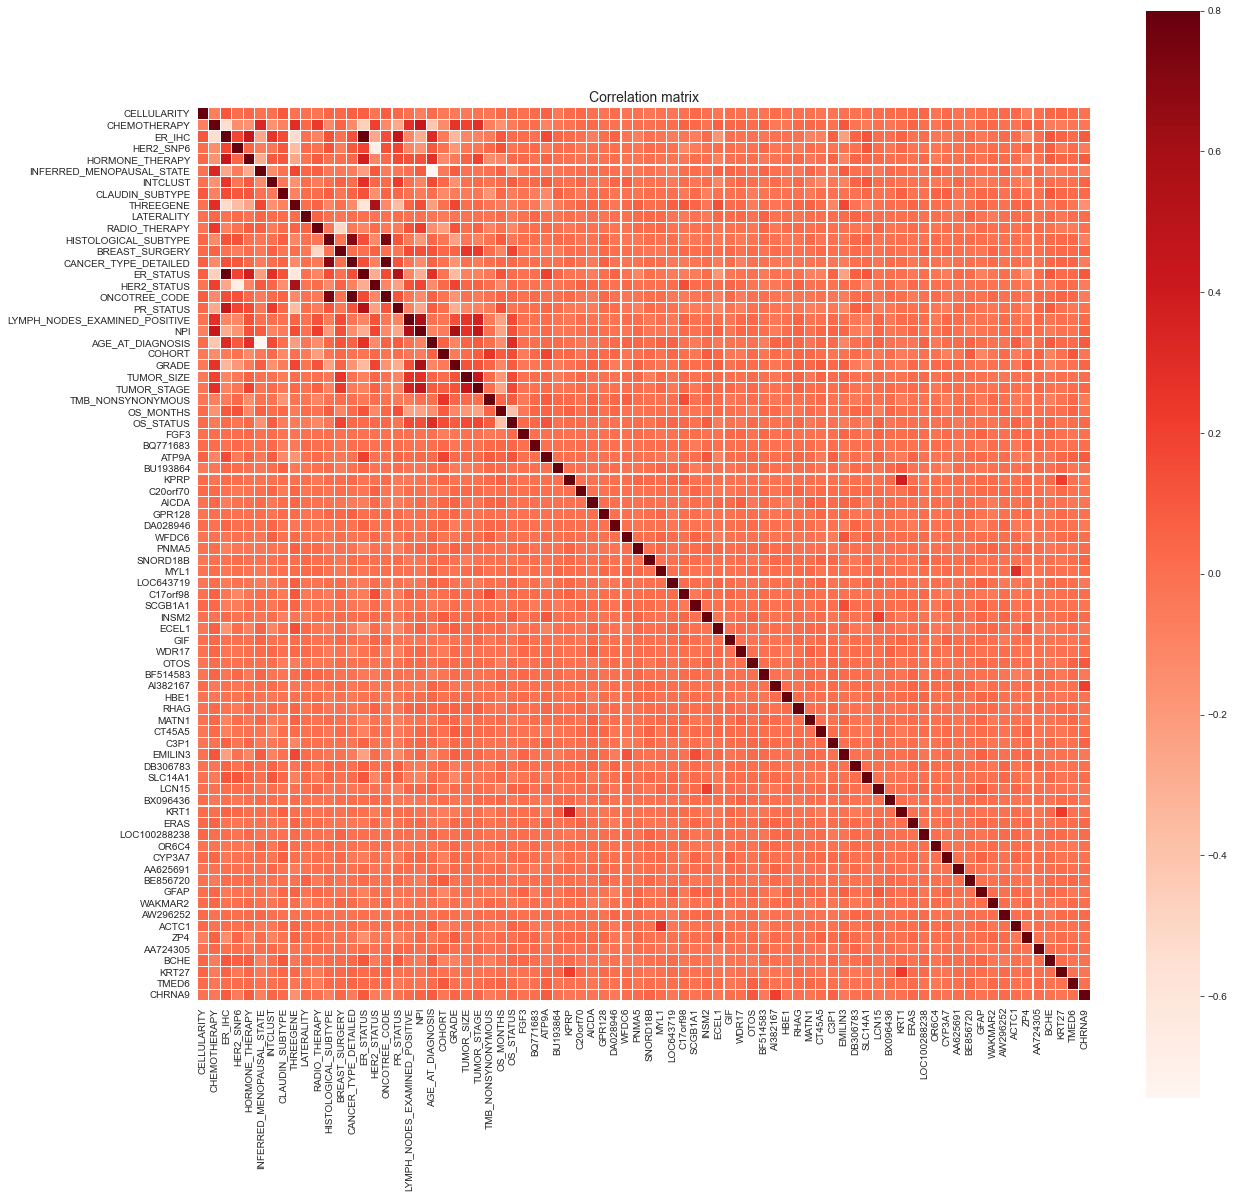

In [38]:
# 4.6 Correlation analysis
# xticklabels=True, yticklabels=True
colormap = plt.cm.Reds
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),linewidths=0.1,vmax=0.8, 
            square=True, cmap = colormap, linecolor='white', xticklabels=True, yticklabels=True )
plt.title('Correlation matrix', fontsize=14)
plt.savefig('Plot\Correlation_Merged.pdf', bbox_inches='tight')
        

42.0% of records are censored


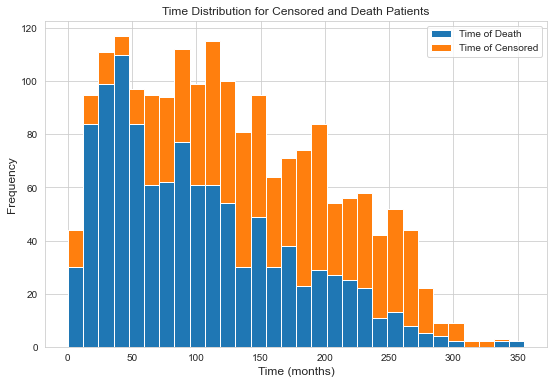

In [39]:
# 4.7 Time Distribution of Death and Censor
num_censored = df.shape[0] - df["OS_STATUS"].sum()
print("%.1f%% of records are censored" % (num_censored/df.shape[0]*100))

plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((df.query('OS_STATUS == 1')['OS_MONTHS'],
                               df.query('OS_STATUS == 0')['OS_MONTHS']),
                              bins=30, stacked=True)
_ = plt.legend(patches, ["Time of Death", "Time of Censored"])
plt.title("Time Distribution for Censored and Death Patients")
plt.xlabel('Time (months)',fontsize='large')
plt.ylabel('Frequency',fontsize='large')
plt.savefig('Plot\Time_Distribution_Merged.pdf') 

In [40]:
# Step 5: Cox survival analysis
# 5.1: Normalise data
ss = MinMaxScaler()
df_norm = df.drop(['OS_STATUS', 'OS_MONTHS'], axis = 1)
df_norm = pd.DataFrame(ss.fit_transform(df_norm), columns=df_norm.columns)
df_norm['OS_STATUS'] = df['OS_STATUS']
df_norm['OS_MONTHS'] = df['OS_MONTHS']


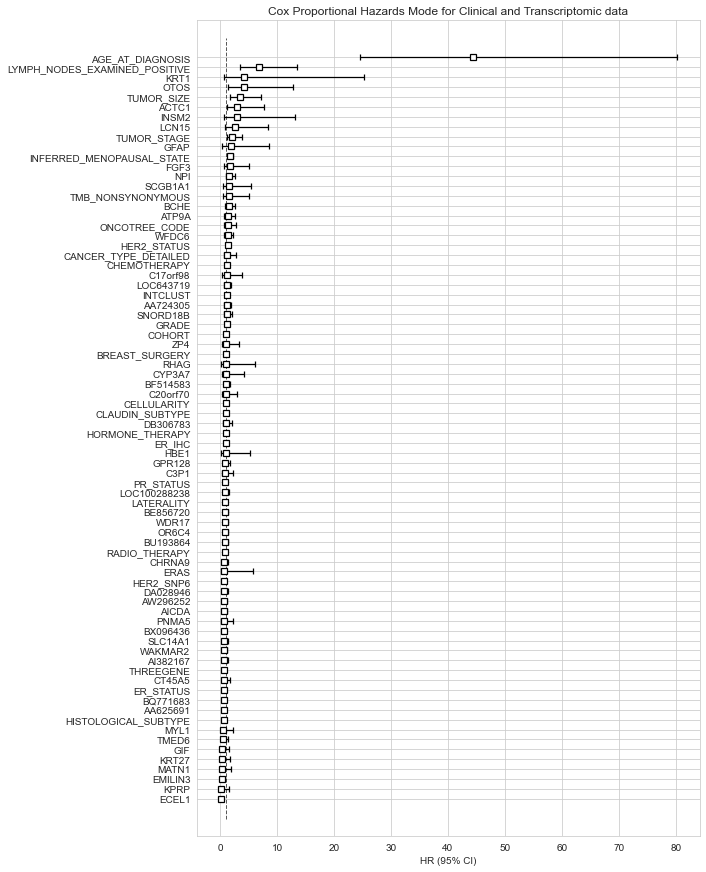

In [41]:
# 5.2: Build model 
# Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df_norm, duration_col='OS_MONTHS', event_col='OS_STATUS')

# Plot

plt.figure(figsize=(9, 15))
plt.title('Cox Proportional Hazards Mode for Clinical and Transcriptomic data')
cph.plot(hazard_ratios=True)
plt.savefig('Plot\CPH_merged.png',bbox_inches='tight')  

In [12]:
# Report
cph.print_summary(columns=["coef","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%", "z", "p"], decimals=3)

<lifelines.CoxPHFitter: fitted with 1903 total observations, 800 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 1903
number of events observed = 1103
   partial log-likelihood = -7262.391
         time fit was run = 2021-12-14 22:52:26 UTC

---
                                coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%      z       p
covariate                                                                                               
CELLULARITY                    0.033      1.034                0.908                1.177  0.501   0.617
CHEMOTHERAPY                   0.257      1.293                1.025                1.631  2.170   0.030
ER_IHC                        -0.028      0.972                0.725                1.304 -0.187   0.851
HER2_SNP6                     -0.269      0.764                0.566                1.032 -1.755   0.079
HORMONE_THERAPY               -0.017      0.983                0.842                1.148 -0.212   0.832
INFERRED_MENOPAUSAL_STATE      0.592      1.807                1.415                2.308  4.743 <0.0005
INTCLUST                       0.154      1.166                0.947                1.437  1.446   0.148
CLAUDIN_SUBTYPE                0.020      1.020                0.800                1.301  0.160   0.873
THREEGENE                     -0.384      0.681                0.507                0.915 -2.552   0.011
LATERALITY                    -0.118      0.889                0.786                1.005 -1.877   0.060
RADIO_THERAPY                 -0.219      0.803                0.681                0.947 -2.610   0.009
HISTOLOGICAL_SUBTYPE          -0.494      0.610                0.349                1.065 -1.739   0.082
BREAST_SURGERY                 0.096      1.100                0.934                1.296  1.142   0.253
CANCER_TYPE_DETAILED           0.264      1.303                0.601                2.821  0.671   0.502
ER_STATUS                     -0.427      0.653                0.488                0.873 -2.873   0.004
HER2_STATUS                    0.268      1.308                0.993                1.722  1.910   0.056
ONCOTREE_CODE                  0.346      1.414                0.707                2.827  0.979   0.327
PR_STATUS                     -0.112      0.894                0.768                1.041 -1.442   0.149
LYMPH_NODES_EXAMINED_POSITIVE  1.918      6.809                3.417               13.570  5.452 <0.0005
NPI                            0.495      1.641                1.019                2.641  2.039   0.041
AGE_AT_DIAGNOSIS               3.793     44.380               24.562               80.188 12.565 <0.0005
COHORT                         0.114      1.121                0.887                1.417  0.955   0.340
GRADE                          0.145      1.156                0.890                1.502  1.087   0.277
TUMOR_SIZE                     1.270      3.562                1.757                7.224  3.522 <0.0005
TUMOR_STAGE                    0.775      2.171                1.227                3.842  2.662   0.008
TMB_NONSYNONYMOUS              0.467      1.596                0.494                5.154  0.781   0.435
FGF3                           0.588      1.801                0.647                5.014  1.126   0.260
BQ771683                      -0.434      0.648                0.388                1.083 -1.657   0.098
ATP9A                          0.354      1.424                0.766                2.648  1.118   0.263
BU193864                      -0.203      0.816                0.510                1.305 -0.849   0.396
KPRP                          -1.421      0.242                0.035                1.649 -1.450   0.147
C20orf70                       0.053      1.054                0.370                3.000  0.099   0.921
AICDA                         -0.301      0.740            

In [13]:
# Cross validation (option)
scores = k_fold_cross_validation(cph, df_norm, 'OS_MONTHS', event_col='OS_STATUS', k=5, 
                                scoring_method="concordance_index", seed=18)

print("Average score", np.mean(scores))

Average score 0.6654543046793661


In [14]:
# Step 6: Machine Learning Methods for Survival Analysis

# 6.1: Set up seed
SEED = 5
CV = KFold(n_splits=5, shuffle=True, random_state=0)

# 6.2 Split data to prepare for ML

X = df.drop(['OS_MONTHS','OS_STATUS'], axis = 1)
df['OS_STATUS'] = np.where(df['OS_STATUS'] == 1, True, False)
y = df[['OS_STATUS','OS_MONTHS']].to_records(index=False)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y['OS_STATUS'],
                                                    random_state=SEED)

In [15]:
# 6.3: Build model

# Define a function for grid search to tune training model
# and predict the results
def grid_search(estimator, param, X_train, y_train, X_test, y_test, CV):
    
    # Define Grid Search
    gcv = GridSearchCV(
    estimator,
    param_grid=param,
    cv=CV,
    n_jobs=-1).fit(X_train, y_train)

    # Find best model
    model = gcv.best_estimator_
    print(model)
    
    # Generate predictions
    prediction = model.predict(X_test)
    result = concordance_index_censored(y_test["OS_STATUS"], y_test["OS_MONTHS"], prediction)
    print('C-index for test set (Hold out):', result[0])

    return [model,  prediction]


In [16]:
# Re-run experiment 20 times 
def c_index(model, X, y, n=20):
    np.random.seed(1)
    seeds = np.random.permutation(1000)[:n]

    # Train and evaluate model with 20 times
    cindex_score = []
    predict_list = []
    
    for s in seeds:
        X_trn, X_test, y_trn, y_test = train_test_split(X, y, test_size=0.2, 
                                                        stratify=y['OS_STATUS'],
                                                        random_state=s)
        model.fit(X_trn, y_trn)
        prediction = model.predict(X_test)
        predict_list.append(prediction)
        result = concordance_index_censored(y_test["OS_STATUS"],y_test["OS_MONTHS"], prediction)
    
        cindex_score.append(round(result[0],3))

    print('Average C-index for {} runs'.format(n), np.mean(cindex_score))
    
    return [cindex_score, predict_list]

In [17]:
# Define the Pipeline and hyperparameter

# CoxPHSurvivalAnalysis
pipe_cox = Pipeline([('scaler', MinMaxScaler()),('model', CoxPHSurvivalAnalysis())])
param_cox ={'scaler': [MinMaxScaler()],
        "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}

# Random Survival Forest
pipe_rsf = Pipeline([('scaler', MinMaxScaler()),('model', RandomSurvivalForest())])
param_rsf ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__max_features': ['sqrt'],
        'model__max_depth': [8],
        'model__min_samples_leaf': [50, 100],
        'model__min_samples_split': [100],
        'model__n_estimators':[500]}

# Gradient Boost Survival
pipe_gbs = Pipeline([('scaler', MinMaxScaler()),('model', GradientBoostingSurvivalAnalysis())])
param_gbs ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__learning_rate': [0.01, 0.1, 1],
        'model__n_estimators':[200, 500, 800, 1000]}

# Survival SVM
pipe_svm = Pipeline([('scaler', MinMaxScaler()),('model', FastSurvivalSVM())])
param_svm ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__max_iter': [500, 5000],
        'model__optimizer':['avltree', 'rbtree','simple']}

# Estimator list:
estimator_list = {'Cox Regression':[pipe_cox, param_cox ], 
                'Random Forest Survival':[pipe_rsf, param_rsf], 
                'Gradient Boosting Survival': [pipe_gbs, param_gbs], 
                'SVM Survival': [pipe_svm, param_svm]}

In [18]:
model_list = []
pred_list = []
c_index_list = []
pred_list_n = []

for model_name, index in estimator_list.items():
    print('\n',model_name)
    estimator = index[0]
    param = index[1]
    outcome = grid_search(estimator, param, X_train, y_train, X_test, y_test, CV)
    model = outcome[0]
    model_list.append(model)
    pred_list.append(outcome[1])

    # Run model n times to check c-index
    score, pre = c_index(model, X, y, n=20)
    c_index_list.append(score)
    pred_list_n.append(pre)

    


 Cox Regression
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', CoxPHSurvivalAnalysis(alpha=1))])
C-index for test set (Hold out): 0.6595035577001718
Average C-index for 20 runs 0.6696

 Random Forest Survival
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 RandomSurvivalForest(max_depth=8, max_features='sqrt',
                                      min_samples_leaf=50,
                                      min_samples_split=100, n_estimators=500,
                                      random_state=5))])
C-index for test set (Hold out): 0.6714238979308088
Average C-index for 20 runs 0.6828000000000001

 Gradient Boosting Survival
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 GradientBoostingSurvivalAnalysis(learning_rate=0.01,
                                                  n_estimators=500,
                                                  random_state=5))])
C-index for test set (Hol

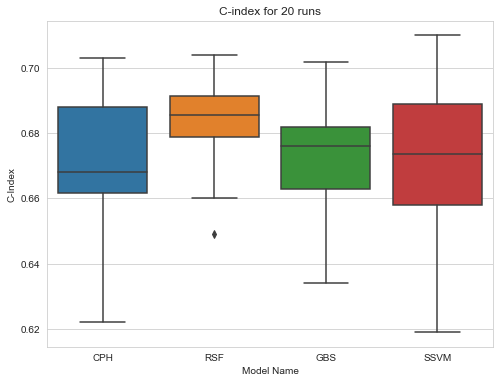

In [19]:
# Visual results

name = ['CPH', 'RSF', 'GBS', 'SSVM']
cv_res = []

for i in range(0,4):
    for c in c_index_list[i]:
        cv_res.append([name[i],c])

c_plot = pd.DataFrame(cv_res, columns=['Model Name','C-Index'])

plt.subplots(figsize=(8,6))
ax = sns.boxplot(x="Model Name", y="C-Index", data=c_plot)
plt.title('C-index for 20 runs')
plt.savefig('Plot\Exp3_cindex.pdf') 

In [24]:
for i in range(0,4):
    print(name[i], np.median(c_index_list[i]))

CPH 0.668
RSF 0.6855
GBS 0.676
SSVM 0.6735


(381, 77)

Model CPH


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          35.20 <0.005     28.33

(381, 77)

Model RSF


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          54.54 <0.005     42.58

(381, 77)

Model GBS


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          39.69 <0.005     31.64

(381, 77)

Model SSVM


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          36.39 <0.005     29.21

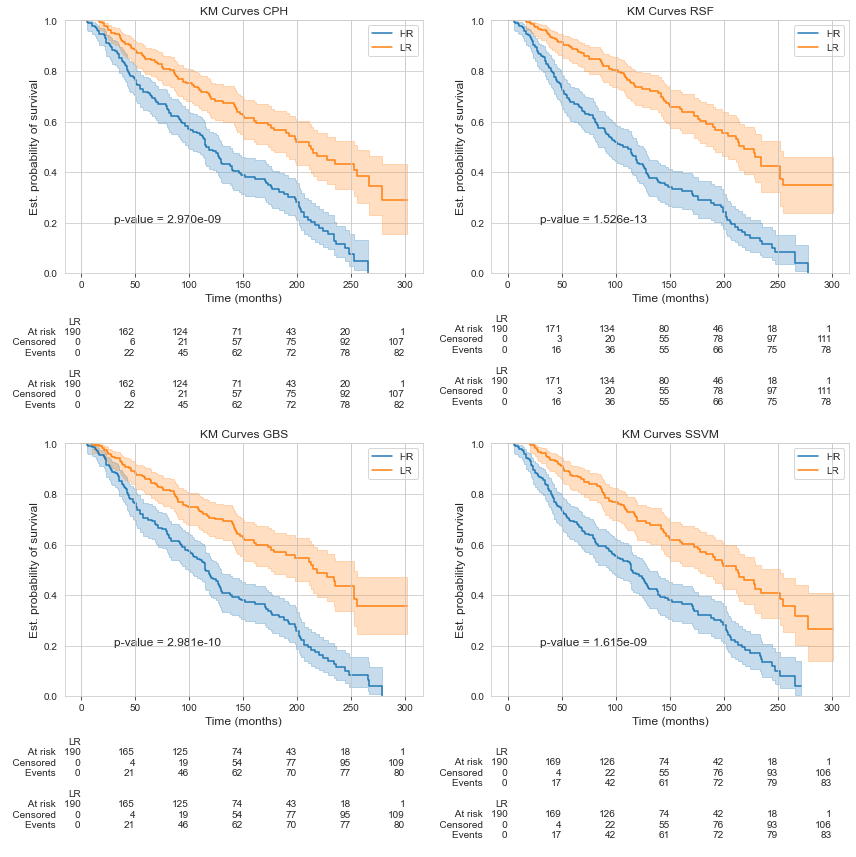

In [21]:
# KM Curve for median
fig, ax = plt.subplots(2,2,figsize=(12,12))
k  = 0
for pred in pred_list:
    df1 = X_test.reset_index(drop=True) 
    risk =[]
    
    y_pred = pred
    med = np.median(y_pred)
    r = np.where(y_pred >= med, 1, 0)

    df1['Risk'] = r
    print(df1.shape)
    ix = df1['Risk'] == 1

    df_y = pd.DataFrame(y_test)
    df_y['OS_STATUS'] = np.where(df_y['OS_STATUS'] == True, 1, 0)
    df1['OS_STATUS']= df_y['OS_STATUS']
    df1['OS_MONTHS']= df_y['OS_MONTHS']
    T_hr, E_hr = df1.loc[ix]['OS_MONTHS'], df1.loc[ix]['OS_STATUS']
    T_lr, E_lr = df1.loc[~ix]['OS_MONTHS'], df1.loc[~ix]['OS_STATUS']

    # Set-up plots
    k+=1
    plt.subplot(2,2,k)

    # Fit survival curves
    kmf_hr = KaplanMeierFitter()
    ax = kmf_hr.fit(T_hr, E_hr, label='HR').plot_survival_function()

    kmf_lr = KaplanMeierFitter()
    ax = kmf_lr.fit(T_lr, E_lr, label='LR').plot_survival_function()

    add_at_risk_counts(kmf_lr, kmf_lr)
    # Format graph
    plt.ylim(0,1)
    ax.set_xlabel('Time (months)',fontsize='large')
    ax.set_ylabel('Est. probability of survival',fontsize='large')

    # Calculate p-value
    res = logrank_test(T_hr, T_lr, event_observed_A=E_hr, event_observed_B=E_lr, alpha=.95)
    print('\nModel', name[k-1])
    res.print_summary()

    # Location the label at the 1st out of 9 tick marks
    xloc = max(np.max(T_hr),np.max(T_lr)) / 10
    ax.text(xloc,.2,'p-value = {:0.3e}'.format(res.p_value),fontsize=12)
    ax.set_title('KM Curves {}' .format(name[k-1]))
    plt.tight_layout()
    plt.savefig('Plot\Exp3_KM.pdf') 

(230, 77)

Model CPH


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          64.04 <0.005     49.54

(230, 77)

Model RSF


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          60.34 <0.005     46.84

(230, 77)

Model GBS


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          49.56 <0.005     38.92

(230, 77)

Model SSVM


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          60.43 <0.005     46.90

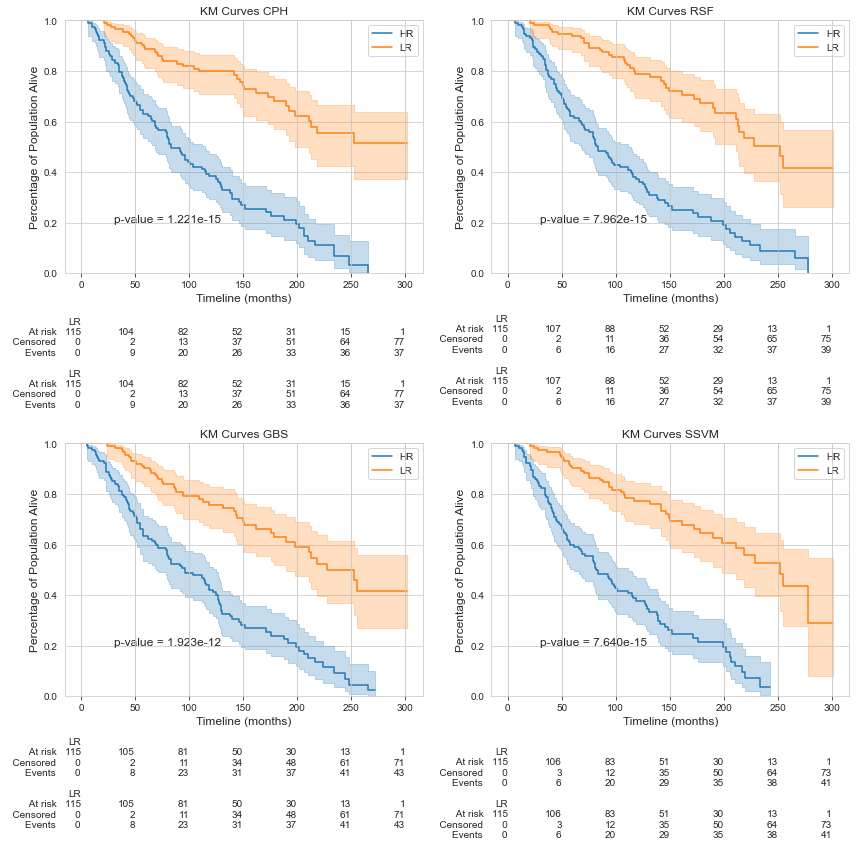

In [21]:
# KM Curves for top and bottom 30%
k  = 0
fig, ax = plt.subplots(2,2,figsize=(12,12))
for pred in pred_list:
    df1 = X_test.reset_index(drop=True)
    risk =[]
    
    y_pred = pred

    top30 = np.quantile(y_pred,0.7)
    bot30 = np.quantile(y_pred, 0.30)
    r = np.where(y_pred >= top30, 1, np.where(y_pred <= bot30, 0, np.nan))
    risk.append(r)

    df1['Risk'] = r
    df1 = df1.dropna(axis=0)
    print(df1.shape)

    ix = df1['Risk'] == 1

    df_y = pd.DataFrame(y_test)
    df_y['OS_STATUS'] = np.where(df_y['OS_STATUS'] == True, 1, 0)
    df1['OS_STATUS']= df_y['OS_STATUS']
    df1['OS_MONTHS']= df_y['OS_MONTHS']
    T_hr, E_hr = df1.loc[ix]['OS_MONTHS'], df1.loc[ix]['OS_STATUS']
    T_lr, E_lr = df1.loc[~ix]['OS_MONTHS'], df1.loc[~ix]['OS_STATUS']

    # Set-up plots
    k+=1
    plt.subplot(2,2,k)

    # Fit survival curves
    kmf_hr = KaplanMeierFitter()
    ax = kmf_hr.fit(T_hr, E_hr, label='HR').plot_survival_function()

    kmf_lr = KaplanMeierFitter()
    ax = kmf_lr.fit(T_lr, E_lr, label='LR').plot_survival_function()

    add_at_risk_counts(kmf_lr, kmf_lr)
    # Format graph
    plt.ylim(0,1);
    ax.set_xlabel('Timeline (months)',fontsize='large')
    ax.set_ylabel('Percentage of Population Alive',fontsize='large')

    # Calculate p-value
    res = logrank_test(T_hr, T_lr, event_observed_A=E_hr, event_observed_B=E_lr, alpha=.95)
    print('\nModel', name[k-1])
    res.print_summary()

    # Location the label at the 1st out of 9 tick marks
    xloc = max(np.max(T_hr),np.max(T_lr)) / 10
    ax.text(xloc,.2, 'p-value = {:0.3e}'.format(res.p_value),fontsize=12)
    ax.set_title('KM Curves {}'.format(name[k-1]))
    plt.tight_layout()
    plt.savefig('Plot\Exp3_KM_topbot.pdf') 


Model CPH


Permutation explainer: 382it [00:16,  9.97it/s]                         


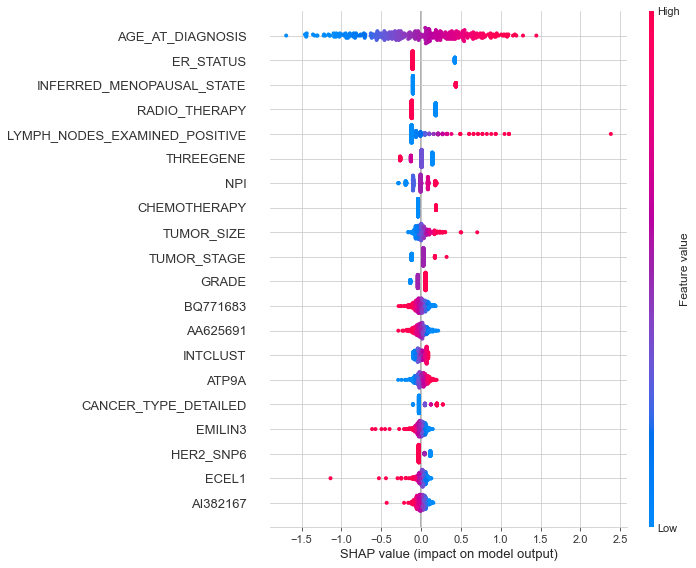


Model RSF


Permutation explainer: 382it [11:43:22, 110.77s/it]


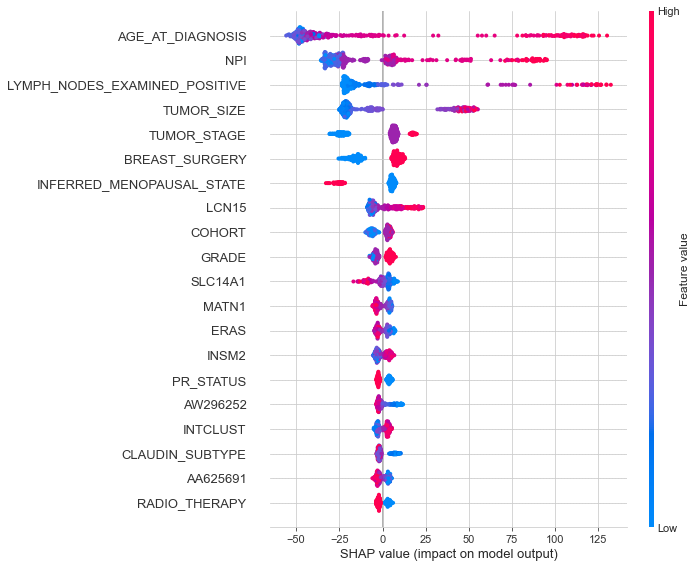


Model GBSurv


Permutation explainer: 382it [02:03,  2.83it/s]


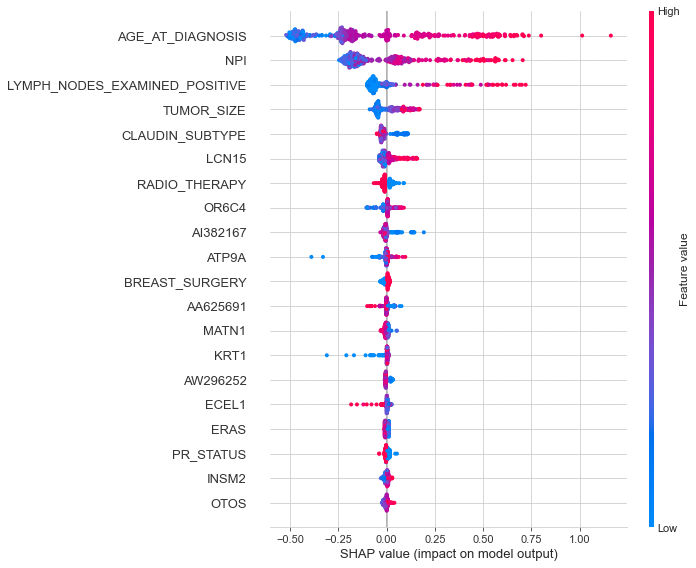


Model SurvSVM


Permutation explainer: 382it [00:12,  6.49it/s]                         


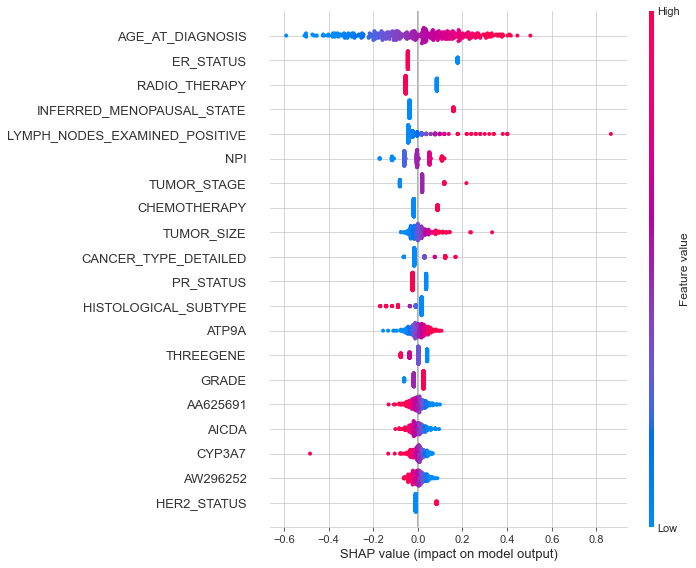

In [22]:
# Interpret data
# # Initialize JS For Plot
shap.initjs()

for i in range(0,4):
    print('\nModel', name[i])
    m = model_list[i][1]
    m.fit(X_train,y_train)
    explainer = shap.Explainer(m.predict, X_train, feature_names=X_train.columns)
    shaps = explainer(X_test)
    shap.summary_plot(shaps, X_test)